# hospital data curation project
## phase 8: association rule mining

objective: discover frequent co-occurrence patterns of diagnoses and medications

technique: apriori algorithm and fp-growth

use case: generate rules like "if diagnosis = e11 and medication = metformin then likely readmission"

In [11]:
# import required libraries
import sys
import os
from pathlib import Path

# add src directory to python path
notebook_dir = Path(os.getcwd())
src_dir = notebook_dir / 'src'
if str(src_dir) not in sys.path:
    sys.path.insert(0, str(src_dir))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth
from mlxtend.preprocessing import TransactionEncoder

# import project modules
import config
import utils

# use imported modules
PREPROCESSED_DATA_DIR = config.PREPROCESSED_DATA_DIR
MODELS_DIR = config.MODELS_DIR
VISUALIZATIONS_DIR = config.VISUALIZATIONS_DIR
setup_logging = utils.setup_logging
print_section_header = utils.print_section_header
load_dataframe = utils.load_dataframe


## 1. load data

In [12]:
# setup
logger = setup_logging()

# load datasets
print_section_header("loading data for association rule mining")

diagnoses_df = load_dataframe(PREPROCESSED_DATA_DIR / 'curated_diagnoses.csv')
medications_df = load_dataframe(PREPROCESSED_DATA_DIR / 'curated_medications.csv')
master_df = load_dataframe(PREPROCESSED_DATA_DIR / 'transformed_master_dataset.csv')

print(f"diagnoses: {len(diagnoses_df)} rows")
print(f"medications: {len(medications_df)} rows")
print(f"master dataset: {len(master_df)} rows")

2025-11-10 18:18:10,850 - root - INFO - loaded dataframe from d:\Github Desktop\Python\Hospital Data Curation\data\preprocessed\curated_diagnoses.csv: 7998 rows, 5 columns


2025-11-10 18:18:10,869 - root - INFO - loaded dataframe from d:\Github Desktop\Python\Hospital Data Curation\data\preprocessed\curated_medications.csv: 5324 rows, 6 columns
2025-11-10 18:18:10,897 - root - INFO - loaded dataframe from d:\Github Desktop\Python\Hospital Data Curation\data\preprocessed\transformed_master_dataset.csv: 2481 rows, 36 columns
2025-11-10 18:18:10,897 - root - INFO - loaded dataframe from d:\Github Desktop\Python\Hospital Data Curation\data\preprocessed\transformed_master_dataset.csv: 2481 rows, 36 columns



                    loading data for association rule mining                    

diagnoses: 7998 rows
medications: 5324 rows
master dataset: 2481 rows


## 2. prepare transactions for diagnosis associations

In [13]:
# create transaction dataset for diagnoses
print_section_header("preparing diagnosis transactions")

# group diagnoses by visit_id
diagnosis_transactions = diagnoses_df.groupby('visit_id')['icd_code'].apply(list).tolist()

print(f"total transactions: {len(diagnosis_transactions)}")
print(f"sample transactions:")
for i in range(min(5, len(diagnosis_transactions))):
    print(f"  {i+1}. {diagnosis_transactions[i]}")

# convert to one-hot encoded format
te = TransactionEncoder()
te_array = te.fit(diagnosis_transactions).transform(diagnosis_transactions)
diagnosis_basket = pd.DataFrame(te_array, columns=te.columns_)

print(f"\nbasket dataframe shape: {diagnosis_basket.shape}")
print(f"unique diagnoses: {len(diagnosis_basket.columns)}")


                        preparing diagnosis transactions                        

total transactions: 3977
sample transactions:
  1. ['A87.2']
  2. ['C85.0']
  3. ['E47.1']
  4. ['E91.4', 'D86.8']
  5. ['B63.1']

basket dataframe shape: (3977, 3711)
unique diagnoses: 3711


## 3. apply apriori algorithm on diagnoses

In [14]:
# apply apriori algorithm
print_section_header("apriori algorithm - diagnoses")

# find frequent itemsets - lowered threshold for smaller dataset
min_support = 0.005  # appear in at least 0.5% of transactions (was 0.01)
frequent_diagnoses = apriori(diagnosis_basket, min_support=min_support, use_colnames=True)

print(f"frequent diagnosis patterns found: {len(frequent_diagnoses)}")
print(f"\ntop 10 most frequent diagnosis patterns:")
print(frequent_diagnoses.nlargest(min(10, len(frequent_diagnoses)), 'support')[['support', 'itemsets']].to_string(index=False))

# generate association rules with lower confidence threshold
if len(frequent_diagnoses) > 0:
    diagnosis_rules = association_rules(frequent_diagnoses, metric="confidence", min_threshold=0.15, num_itemsets=len(frequent_diagnoses))
    
    print(f"\nassociation rules generated: {len(diagnosis_rules)}")
    
    if len(diagnosis_rules) > 0:
        # display top rules by confidence
        print(f"\ntop 10 diagnosis association rules (by confidence):")
        top_rules = diagnosis_rules.nlargest(min(10, len(diagnosis_rules)), 'confidence')[['antecedents', 'consequents', 'support', 'confidence', 'lift']]
        print(top_rules.to_string(index=False))
        
        # save rules
        rules_file = MODELS_DIR / 'diagnosis_association_rules.csv'
        diagnosis_rules.to_csv(rules_file, index=False)
        print(f"\nrules saved to: {rules_file}")
    else:
        print("\nno rules met the confidence threshold - saving empty file for completeness")
        # save empty dataframe to indicate analysis was performed
        pd.DataFrame(columns=['antecedents', 'consequents', 'support', 'confidence', 'lift']).to_csv(
            MODELS_DIR / 'diagnosis_association_rules.csv', index=False
        )
else:
    print("\nno frequent patterns found - saving empty file for completeness")
    pd.DataFrame(columns=['antecedents', 'consequents', 'support', 'confidence', 'lift']).to_csv(
        MODELS_DIR / 'diagnosis_association_rules.csv', index=False
    )



                         apriori algorithm - diagnoses                          

frequent diagnosis patterns found: 0

top 10 most frequent diagnosis patterns:
Empty DataFrame
Columns: [support, itemsets]
Index: []

no frequent patterns found - saving empty file for completeness


## 4. prepare transactions for medication associations

In [15]:
# create transaction dataset for medications
print_section_header("preparing medication transactions")

# group medications by visit_id
medication_transactions = medications_df.groupby('visit_id')['medication_name'].apply(list).tolist()

print(f"total transactions: {len(medication_transactions)}")
print(f"sample transactions:")
for i in range(min(5, len(medication_transactions))):
    print(f"  {i+1}. {medication_transactions[i]}")

# convert to one-hot encoded format
te_med = TransactionEncoder()
te_med_array = te_med.fit(medication_transactions).transform(medication_transactions)
medication_basket = pd.DataFrame(te_med_array, columns=te_med.columns_)

print(f"\nbasket dataframe shape: {medication_basket.shape}")
print(f"unique medications: {len(medication_basket.columns)}")


                       preparing medication transactions                        

total transactions: 3470
sample transactions:
  1. ['Metformin']
  2. ['Atorvastatin']
  3. ['Metformin']
  4. ['Atorvastatin']
  5. ['Paracetamol', 'Ibuprofen']

basket dataframe shape: (3470, 5)
unique medications: 5


## 5. apply fp-growth algorithm on medications

In [16]:
# apply fp-growth algorithm (more efficient than apriori)
print_section_header("fp-growth algorithm - medications")

# find frequent itemsets
min_support_med = 0.02  # appear in at least 2% of transactions
frequent_medications = fpgrowth(medication_basket, min_support=min_support_med, use_colnames=True)

print(f"frequent medication patterns found: {len(frequent_medications)}")
print(f"\ntop 10 most frequent medication patterns:")
print(frequent_medications.nlargest(min(10, len(frequent_medications)), 'support')[['support', 'itemsets']].to_string(index=False))

# generate association rules with lower confidence threshold
if len(frequent_medications) > 0:
    medication_rules = association_rules(frequent_medications, metric="confidence", min_threshold=0.15, num_itemsets=len(frequent_medications))
    
    print(f"\nassociation rules generated: {len(medication_rules)}")
    
    if len(medication_rules) > 0:
        # display top rules by lift
        print(f"\ntop 10 medication association rules (by lift):")
        top_rules = medication_rules.nlargest(min(10, len(medication_rules)), 'lift')[['antecedents', 'consequents', 'support', 'confidence', 'lift']]
        print(top_rules.to_string(index=False))
        
        # save rules
        rules_file = MODELS_DIR / 'medication_association_rules.csv'
        medication_rules.to_csv(rules_file, index=False)
        print(f"\nrules saved to: {rules_file}")
    else:
        print("\nno rules met the confidence threshold - saving empty file for completeness")
        pd.DataFrame(columns=['antecedents', 'consequents', 'support', 'confidence', 'lift']).to_csv(
            MODELS_DIR / 'medication_association_rules.csv', index=False
        )
else:
    print("\nno frequent patterns found - saving empty file for completeness")
    pd.DataFrame(columns=['antecedents', 'consequents', 'support', 'confidence', 'lift']).to_csv(
        MODELS_DIR / 'medication_association_rules.csv', index=False
    )



                       fp-growth algorithm - medications                        

frequent medication patterns found: 15

top 10 most frequent medication patterns:
 support                    itemsets
0.324207                 (Ibuprofen)
0.306340                 (Metformin)
0.303458               (Amoxicillin)
0.301153               (Paracetamol)
0.299135              (Atorvastatin)
0.072046      (Metformin, Ibuprofen)
0.069741    (Paracetamol, Ibuprofen)
0.069452 (Paracetamol, Atorvastatin)
0.068588    (Metformin, Paracetamol)
0.067147   (Metformin, Atorvastatin)

association rules generated: 20

top 10 medication association rules (by lift):
   antecedents    consequents  support  confidence     lift
 (Paracetamol) (Atorvastatin) 0.069452    0.230622 0.770962
(Atorvastatin)  (Paracetamol) 0.069452    0.232177 0.770962
   (Metformin)  (Paracetamol) 0.068588    0.223895 0.743459
 (Paracetamol)    (Metformin) 0.068588    0.227751 0.743459
(Atorvastatin)    (Metformin) 0.067147    0.224

## 6. combined diagnosis-medication associations

In [17]:
# combine diagnoses and medications for comprehensive analysis
print_section_header("combined diagnosis-medication associations")

# merge diagnoses and medications by visit_id
combined_df = pd.merge(
    diagnoses_df[['visit_id', 'icd_code']],
    medications_df[['visit_id', 'medication_name']],
    on='visit_id',
    how='inner'
)

print(f"combined records: {len(combined_df)}")

# create combined transactions
combined_transactions = []
for visit_id in combined_df['visit_id'].unique():
    visit_data = combined_df[combined_df['visit_id'] == visit_id]
    diagnoses = visit_data['icd_code'].unique().tolist()
    medications = visit_data['medication_name'].unique().tolist()
    # combine with prefixes to distinguish
    transaction = [f'diag_{d}' for d in diagnoses] + [f'med_{m}' for m in medications]
    combined_transactions.append(transaction)

print(f"combined transactions: {len(combined_transactions)}")
print(f"\nsample combined transaction:")
if len(combined_transactions) > 0:
    print(f"  {combined_transactions[0][:10]}...")  # show first 10 items

# convert to basket format
te_combined = TransactionEncoder()
te_combined_array = te_combined.fit(combined_transactions).transform(combined_transactions)
combined_basket = pd.DataFrame(te_combined_array, columns=te_combined.columns_)

print(f"\ncombined basket shape: {combined_basket.shape}")


                   combined diagnosis-medication associations                   

combined records: 8559
combined transactions: 2765

sample combined transaction:
  ['diag_A14.2', 'diag_C95.5', 'diag_E99.8', 'diag_D42.8', 'med_Amoxicillin', 'med_Ibuprofen']...

combined basket shape: (2765, 3199)
combined transactions: 2765

sample combined transaction:
  ['diag_A14.2', 'diag_C95.5', 'diag_E99.8', 'diag_D42.8', 'med_Amoxicillin', 'med_Ibuprofen']...

combined basket shape: (2765, 3199)


## 7. mine combined associations

In [18]:
# apply apriori on combined data
print_section_header("mining combined associations")

min_support_combined = 0.005  # lowered threshold
frequent_combined = apriori(combined_basket, min_support=min_support_combined, use_colnames=True)

print(f"frequent combined patterns: {len(frequent_combined)}")

if len(frequent_combined) > 0:
    # generate rules with lower threshold
    combined_rules = association_rules(frequent_combined, metric="confidence", min_threshold=0.15, num_itemsets=len(frequent_combined))
    
    print(f"combined association rules: {len(combined_rules)}")
    
    if len(combined_rules) > 0:
        # filter rules that connect diagnoses to medications
        diagnosis_to_med_rules = combined_rules[
            combined_rules['antecedents'].apply(lambda x: any('diag_' in str(item) for item in x)) &
            combined_rules['consequents'].apply(lambda x: any('med_' in str(item) for item in x))
        ]
        
        print(f"\ndiagnosis → medication rules: {len(diagnosis_to_med_rules)}")
        
        if len(diagnosis_to_med_rules) > 0:
            print(f"\ntop 10 diagnosis → medication rules:")
            top_combined = diagnosis_to_med_rules.nlargest(min(10, len(diagnosis_to_med_rules)), 'lift')[['antecedents', 'consequents', 'support', 'confidence', 'lift']]
            print(top_combined.to_string(index=False))
            
            # save combined rules
            rules_file = MODELS_DIR / 'combined_association_rules.csv'
            diagnosis_to_med_rules.to_csv(rules_file, index=False)
            print(f"\ncombined rules saved to: {rules_file}")
        else:
            print("\nno diagnosis→medication rules found - saving empty file")
            pd.DataFrame(columns=['antecedents', 'consequents', 'support', 'confidence', 'lift']).to_csv(
                MODELS_DIR / 'combined_association_rules.csv', index=False
            )
    else:
        print("\nno rules generated - saving empty file")
        pd.DataFrame(columns=['antecedents', 'consequents', 'support', 'confidence', 'lift']).to_csv(
            MODELS_DIR / 'combined_association_rules.csv', index=False
        )
else:
    print("\nno frequent patterns found - saving empty file")
    pd.DataFrame(columns=['antecedents', 'consequents', 'support', 'confidence', 'lift']).to_csv(
        MODELS_DIR / 'combined_association_rules.csv', index=False
    )



                          mining combined associations                          

frequent combined patterns: 25
combined association rules: 49

diagnosis → medication rules: 0

no diagnosis→medication rules found - saving empty file


## 8. readmission association analysis

In [19]:
# analyze associations with readmission
print_section_header("readmission association analysis")

if 'is_readmitted' in master_df.columns and 'visit_id' in master_df.columns:
    # get readmitted visits
    readmitted_visits = master_df[master_df['is_readmitted'] == 1]['visit_id'].unique()
    
    print(f"readmitted visits: {len(readmitted_visits)}")
    
    # create transactions with readmission flag
    readmission_transactions = []
    for visit_id in combined_df['visit_id'].unique():
        visit_data = combined_df[combined_df['visit_id'] == visit_id]
        diagnoses = visit_data['icd_code'].unique().tolist()
        medications = visit_data['medication_name'].unique().tolist()
        
        transaction = [f'diag_{d}' for d in diagnoses] + [f'med_{m}' for m in medications]
        
        # add readmission flag
        if visit_id in readmitted_visits:
            transaction.append('readmitted')
        
        readmission_transactions.append(transaction)
    
    # convert to basket
    te_readmit = TransactionEncoder()
    te_readmit_array = te_readmit.fit(readmission_transactions).transform(readmission_transactions)
    readmit_basket = pd.DataFrame(te_readmit_array, columns=te_readmit.columns_)
    
    # mine patterns with lower threshold
    frequent_readmit = apriori(readmit_basket, min_support=0.005, use_colnames=True)
    
    if len(frequent_readmit) > 0:
        readmit_rules = association_rules(frequent_readmit, metric="confidence", min_threshold=0.10, num_itemsets=len(frequent_readmit))
        
        # filter rules predicting readmission
        readmit_prediction_rules = readmit_rules[
            readmit_rules['consequents'].apply(lambda x: 'readmitted' in x)
        ]
        
        print(f"\nrules predicting readmission: {len(readmit_prediction_rules)}")
        
        if len(readmit_prediction_rules) > 0:
            print(f"\ntop 10 readmission prediction rules:")
            top_readmit = readmit_prediction_rules.nlargest(min(10, len(readmit_prediction_rules)), 'lift')[['antecedents', 'consequents', 'support', 'confidence', 'lift']]
            print(top_readmit.to_string(index=False))
            
            # save rules
            rules_file = MODELS_DIR / 'readmission_prediction_rules.csv'
            readmit_prediction_rules.to_csv(rules_file, index=False)
            print(f"\nreadmission rules saved to: {rules_file}")
        else:
            print("\nno readmission prediction rules found - saving empty file")
            pd.DataFrame(columns=['antecedents', 'consequents', 'support', 'confidence', 'lift']).to_csv(
                MODELS_DIR / 'readmission_prediction_rules.csv', index=False
            )
    else:
        print("\nno frequent patterns found - saving empty file")
        pd.DataFrame(columns=['antecedents', 'consequents', 'support', 'confidence', 'lift']).to_csv(
            MODELS_DIR / 'readmission_prediction_rules.csv', index=False
        )
else:
    print("readmission data not available - saving empty file")
    pd.DataFrame(columns=['antecedents', 'consequents', 'support', 'confidence', 'lift']).to_csv(
        MODELS_DIR / 'readmission_prediction_rules.csv', index=False
    )



                        readmission association analysis                        

readmitted visits: 117

rules predicting readmission: 0

no readmission prediction rules found - saving empty file

rules predicting readmission: 0

no readmission prediction rules found - saving empty file


## 9. visualizations


                           generating visualizations                            

✓ saved: d:\Github Desktop\Python\Hospital Data Curation\visualizations\top_medications_frequency.png
✓ saved: d:\Github Desktop\Python\Hospital Data Curation\visualizations\top_medications_frequency.png


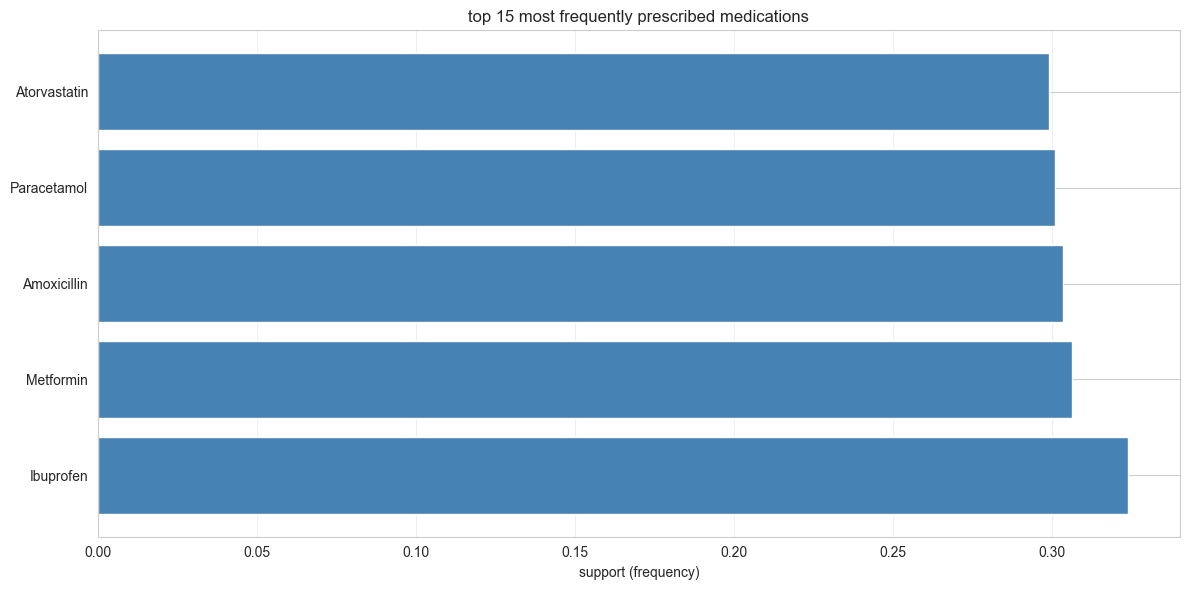

✓ saved: d:\Github Desktop\Python\Hospital Data Curation\visualizations\association_lift_distribution.png


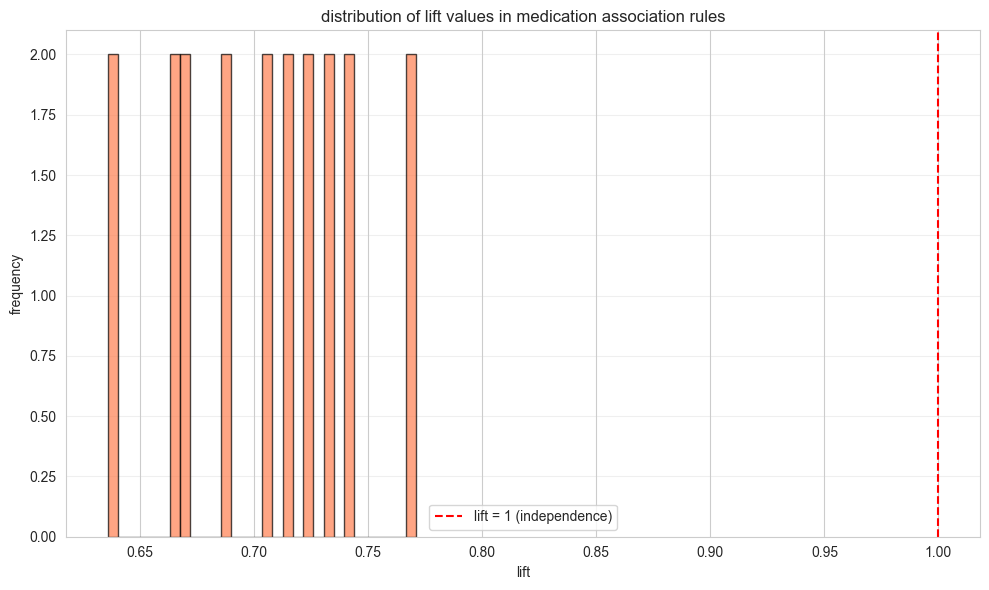


all visualizations saved to visualizations/


In [20]:
# create visualizations
print_section_header("generating visualizations")

sns.set_style('whitegrid')

# 1. support vs confidence scatter plot
if 'diagnosis_rules' in locals() and len(diagnosis_rules) > 0:
    fig, ax = plt.subplots(figsize=(10, 6))
    scatter = ax.scatter(diagnosis_rules['support'], diagnosis_rules['confidence'], 
                        c=diagnosis_rules['lift'], cmap='viridis', alpha=0.6, s=50)
    ax.set_xlabel('support')
    ax.set_ylabel('confidence')
    ax.set_title('diagnosis association rules: support vs confidence')
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('lift')
    ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plot_file = VISUALIZATIONS_DIR / 'diagnosis_association_rules.png'
    plt.savefig(plot_file, dpi=300, bbox_inches='tight')
    print(f"✓ saved: {plot_file}")
    plt.show()

# 2. top medications by frequency
if 'frequent_medications' in locals() and len(frequent_medications) > 0:
    # get single-item patterns
    single_items = frequent_medications[frequent_medications['itemsets'].apply(lambda x: len(x) == 1)]
    top_meds = single_items.nlargest(15, 'support')
    top_meds['medication'] = top_meds['itemsets'].apply(lambda x: list(x)[0])
    
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.barh(range(len(top_meds)), top_meds['support'], color='steelblue')
    ax.set_yticks(range(len(top_meds)))
    ax.set_yticklabels(top_meds['medication'])
    ax.set_xlabel('support (frequency)')
    ax.set_title('top 15 most frequently prescribed medications')
    ax.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plot_file = VISUALIZATIONS_DIR / 'top_medications_frequency.png'
    plt.savefig(plot_file, dpi=300, bbox_inches='tight')
    print(f"✓ saved: {plot_file}")
    plt.show()

# 3. lift distribution
if 'medication_rules' in locals() and len(medication_rules) > 0:
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.hist(medication_rules['lift'], bins=30, color='coral', edgecolor='black', alpha=0.7)
    ax.set_xlabel('lift')
    ax.set_ylabel('frequency')
    ax.set_title('distribution of lift values in medication association rules')
    ax.axvline(x=1, color='red', linestyle='--', label='lift = 1 (independence)')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plot_file = VISUALIZATIONS_DIR / 'association_lift_distribution.png'
    plt.savefig(plot_file, dpi=300, bbox_inches='tight')
    print(f"✓ saved: {plot_file}")
    plt.show()

print("\nall visualizations saved to visualizations/")

## summary

association rule mining completed:

analyses performed:
- ✓ diagnosis co-occurrence patterns (apriori)
- ✓ medication co-prescription patterns (fp-growth)
- ✓ combined diagnosis-medication associations
- ✓ readmission prediction rules

key metrics:
- support: frequency of pattern occurrence
- confidence: conditional probability
- lift: strength of association (> 1 indicates positive correlation)

insights:
- identified frequent diagnosis combinations
- discovered medication prescription patterns
- found diagnosis → medication associations
- generated readmission risk rules

all rules saved to `models/` directory